In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score,fbeta_score
from sklearn.base import clone
import shap
import optuna


C:\Users\vicsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DIR = "C:/Users/vicsa/OneDrive/Documents/Personal/Master_DataScience_UBA/3er Cuatrimestre/Proyecto_Tesis/Data_Tesis/CSV/"
df = pd.read_csv(DIR + "BD_final_Corregida.csv")

,Site Name,year,week,uptime_min,uptime_mean,uptime_max,uptime_var,n_tech,FEC_FIN,REGION,...,cnt_srv_Poda de árboles,cnt_srv_RECTIFICADOR,cnt_srv_SE,cnt_srv_SISTEMA ELECTRICO,cnt_srv_SISTEMA SEGURIDAD,"cnt_srv_Siniestros, Accidentes de Transito, Corto Circuito",cnt_srv_TRABAJOS TERCEROS,cnt_srv_Trabajo de otros Operadores,cnt_srv_UPS,"cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)"
0,10_DE_SEPTIEMBRE,2024,26,49.785948,74.707171,99.628395,1242.134779,2,29/06/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10_DE_SEPTIEMBRE,2024,27,97.418100,98.287161,99.156222,1.510535,2,6/07/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10_DE_SEPTIEMBRE,2024,28,100.000000,100.000000,100.000000,0.000000,2,13/07/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10_DE_SEPTIEMBRE,2024,29,100.000000,100.000000,100.000000,0.000000,2,20/07/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10_DE_SEPTIEMBRE,2024,30,100.000000,100.000000,100.000000,0.000000,2,27/07/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Engineering

## Variables Temporales

In [ ]:
df = df.sort_values(['ID', 'week'])

# Creo Variables lag para uptime_min
for lag in [1, 2, 3]:
    df[f'uptime_min_t-{lag}'] = df.groupby('ID')['uptime_min'].shift(lag)

# Creo media móvil de 3 semanas
df['uptime_rolling_mean_3w'] = (
    df.groupby('ID')['uptime_min']
    .shift(1)
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# Creo lags para métricas relacionadas a incidentes
df['n_alarms_t-1'] = df.groupby('ID')['n_alarms'].shift(1)
df['total_dur_caida_t-1'] = df.groupby('ID')['total_dur_caida'].shift(1)

,Site Name,year,week,uptime_min,uptime_mean,uptime_max,uptime_var,n_tech,FEC_FIN,REGION,...,cnt_srv_TRABAJOS TERCEROS,cnt_srv_Trabajo de otros Operadores,cnt_srv_UPS,"cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)",uptime_min_t-1,uptime_min_t-2,uptime_min_t-3,uptime_rolling_mean_3w,n_alarms_t-1,total_dur_caida_t-1
25990,HUACRACHUCO_PUEBLO,2024,10,33.317935,33.317935,33.317935,NaN,1,9/03/2024,NORTE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.998775,NaN,NaN
25991,HUACRACHUCO_PUEBLO,2024,11,99.604444,99.802222,100.000000,0.078232,2,16/03/2024,NORTE,...,NaN,NaN,NaN,NaN,33.317935,NaN,NaN,99.994366,NaN,NaN
25992,HUACRACHUCO_PUEBLO,2024,12,99.921645,99.932852,99.944059,0.000251,2,23/03/2024,NORTE,...,NaN,NaN,NaN,NaN,99.604444,33.317935,NaN,99.256087,NaN,NaN
25993,HUACRACHUCO_PUEBLO,2024,13,95.099041,97.380201,99.661362,10.407386,2,30/03/2024,NORTE,...,NaN,NaN,NaN,NaN,99.921645,99.604444,33.317935,99.254801,NaN,NaN
25994,HUACRACHUCO_PUEBLO,2024,14,100.000000,100.000000,100.000000,0.000000,2,6/04/2024,NORTE,...,NaN,NaN,NaN,NaN,95.099041,99.921645,99.604444,99.258843,NaN,NaN


## Variables Derivadas

In [ ]:
# Convierto FEC_FIN a tipo datetime
df['FEC_FIN'] = pd.to_datetime(df['FEC_FIN'], format='%d/%m/%Y', errors='coerce')

# Derivo el mes
df['month'] = df['FEC_FIN'].dt.month

# Derivo a la variable binaria is_holiday con feriados nacionales comunes en Perú
feriados = ['01-01','03-28','03-29','05-01','06-29', '07-28', '07-29','08-30','11-01', '12-25']
df['is_holiday'] = df['FEC_FIN'].dt.strftime('%m-%d').isin(feriados).astype(int)

,Site Name,year,week,uptime_min,uptime_mean,uptime_max,uptime_var,n_tech,FEC_FIN,REGION,...,cnt_srv_UPS,"cnt_srv_Vandalismo(Sabotaje,Robos de Mufa, Robos de cable)",uptime_min_t-1,uptime_min_t-2,uptime_min_t-3,uptime_rolling_mean_3w,n_alarms_t-1,total_dur_caida_t-1,month,is_holiday
25990,HUACRACHUCO_PUEBLO,2024,10,33.317935,33.317935,33.317935,NaN,1,2024-03-09,NORTE,...,NaN,NaN,NaN,NaN,NaN,99.998775,NaN,NaN,3,0
25991,HUACRACHUCO_PUEBLO,2024,11,99.604444,99.802222,100.000000,0.078232,2,2024-03-16,NORTE,...,NaN,NaN,33.317935,NaN,NaN,99.994366,NaN,NaN,3,0
25992,HUACRACHUCO_PUEBLO,2024,12,99.921645,99.932852,99.944059,0.000251,2,2024-03-23,NORTE,...,NaN,NaN,99.604444,33.317935,NaN,99.256087,NaN,NaN,3,0
25993,HUACRACHUCO_PUEBLO,2024,13,95.099041,97.380201,99.661362,10.407386,2,2024-03-30,NORTE,...,NaN,NaN,99.921645,99.604444,33.317935,99.254801,NaN,NaN,3,0
25994,HUACRACHUCO_PUEBLO,2024,14,100.000000,100.000000,100.000000,0.000000,2,2024-04-06,NORTE,...,NaN,NaN,95.099041,99.921645,99.604444,99.258843,NaN,NaN,4,0


## Variables Categoricas

In [ ]:
# Codificación de ZONA
le = LabelEncoder()
df['ZONA_encoded'] = le.fit_transform(df['ZONA'])
zona_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("ZONA codificada:", zona_map)

ZONA codificada: {'REGION_A': np.int64(0), 'REGION_B': np.int64(1), 'REGION_C': np.int64(2), 'REGION_D': np.int64(3), 'REGION_E': np.int64(4), 'REGION_F': np.int64(5), 'REGION_G': np.int64(6), 'REGION_H': np.int64(7), 'REGION_I': np.int64(8), 'REGION_J': np.int64(9)}


In [ ]:
#Clusterización de Estaciones

#Calculo media y desviación estándar por estación
df_cluster = df.groupby('ID')['uptime_min'].agg(['mean', 'std']).reset_index()

#Reemplazar NaNs en media y std
df_cluster['std'] = df_cluster['std'].fillna(0)

#Escalado y clustering
X = df_cluster.drop('ID', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=260525)
df_cluster['station_cluster'] = kmeans.fit_predict(X_scaled)

df = df.merge(df_cluster[['ID', 'station_cluster']], on='ID', how='left')
df.head()

,Site Name,year,week,uptime_min,uptime_mean,uptime_max,uptime_var,n_tech,FEC_FIN,REGION,...,uptime_min_t-1,uptime_min_t-2,uptime_min_t-3,uptime_rolling_mean_3w,n_alarms_t-1,total_dur_caida_t-1,month,is_holiday,ZONA_encoded,station_cluster
0,HUACRACHUCO_PUEBLO,2024,10,33.317935,33.317935,33.317935,NaN,1,2024-03-09,NORTE,...,NaN,NaN,NaN,99.998775,NaN,NaN,3,0,8,1
1,HUACRACHUCO_PUEBLO,2024,11,99.604444,99.802222,100.000000,0.078232,2,2024-03-16,NORTE,...,33.317935,NaN,NaN,99.994366,NaN,NaN,3,0,8,1
2,HUACRACHUCO_PUEBLO,2024,12,99.921645,99.932852,99.944059,0.000251,2,2024-03-23,NORTE,...,99.604444,33.317935,NaN,99.256087,NaN,NaN,3,0,8,1
3,HUACRACHUCO_PUEBLO,2024,13,95.099041,97.380201,99.661362,10.407386,2,2024-03-30,NORTE,...,99.921645,99.604444,33.317935,99.254801,NaN,NaN,3,0,8,1
4,HUACRACHUCO_PUEBLO,2024,14,100.000000,100.000000,100.000000,0.000000,2,2024-04-06,NORTE,...,95.099041,99.921645,99.604444,99.258843,NaN,NaN,4,0,8,1


## Variable pct_uptime_target
Dado que mi objetivo es el de predecir la disponibilidad de la proxima semana, añadire a cada entrada el valor de la variable uptime_pct_min de la siguiente semana. Este pasara a llamarse uptime_pct_target

In [ ]:
df_model = df.copy()
df_model["uptime_pct_target"] = (
    df_model.sort_values(["ID", "year", "week"])
            .groupby("ID")["uptime_min"]
            .shift(-1)
)

# Elimino filas sin target
df_model = df_model.dropna(subset=["uptime_pct_target"])

## Variable Predictiva de Modelo Clasificatorio
Durante la fase inicial del modelado predictivo, se implementaron modelos de regresión utilizando algoritmos como Random Forest Regressor y XGBoost Regressor, con el objetivo de predecir el valor exacto de uptime_pct_target para cada estación en la semana siguiente.

Si bien las métricas obtenidas (MAE < 0.75) indicaban una precisión razonable en la magnitud del error, el análisis de la métrica R² reveló una baja capacidad explicativa del modelo en semanas recientes (incluso con valores negativos), lo cual sugiere una dificultad del modelo para generalizar correctamente ante cambios de patrón o ruido en los datos.

Por estos motivos, se optó por reformular el problema como una tarea de clasificación, más alineada con la toma de decisiones operativas. En lugar de predecir un valor continuo, el objetivo pasa a ser identificar si una estación estará o no en riesgo de baja disponibilidad, a partir de un umbral definido (por ejemplo, uptime_pct_target < 98.5%).

In [9]:
#Genero nueva variable target, 1 = en riesgo, 0 = estable
df_model['uptime_class'] = (df_model['uptime_pct_target'] < 98.5).astype(int)
print(df_model['uptime_class'].value_counts(normalize=True))

uptime_class
0    0.893654
1    0.106346
Name: proportion, dtype: float64


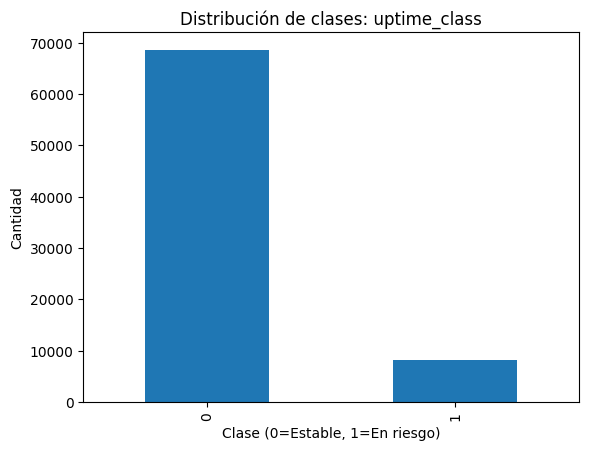

In [10]:
df_model['uptime_class'].value_counts().plot(kind='bar')
plt.title('Distribución de clases: uptime_class')
plt.xlabel('Clase (0=Estable, 1=En riesgo)')
plt.ylabel('Cantidad')
plt.show()

Las siguientes variables transformadas se crean para reducir la alta colinealidad entre las estadísticas agregadas (mean, max, var) y la variable objetivo (uptime_pct_target). En lugar de usar directamente estos valores, se calculan diferencias ('gap') que capturan la dispersión interna entre tecnologías dentro de cada estación, sin inducir sobreajuste.

In [11]:
df_model["gap_mean"] = df_model["uptime_mean"] - df_model["uptime_min"]
df_model["gap_max"] = df_model["uptime_max"] - df_model["uptime_min"]
df_model["gap_var"] = df_model["uptime_var"] 

Elimino columnas que no usare en mi modelo

In [12]:
columnas_descartar = [
    'REGION', 'SUB_REGION', 'PROVINCIA', 'DISTRITO', 'Site Name',
    'TECNOLOGIA', 'COND_RADAR', 'SITE_norm', 'ZONA', 'ID', 'Site Name', 'uptime_pct_target'
]
df = df_model.drop(columns=columnas_descartar, errors='ignore')

# Construcción y validación de Modelos

## Modelo Global

In [ ]:
#Preparación de Datos para cada Modelo
# Columnas a excluir
columnas_a_excluir = [
    "FEC_FIN",
    "AVAILABILITY_NUM", "AVAILABILITY_DEN",
    "year", "week",
    "uptime_pct_target", "uptime_mean", "uptime_max", "uptime_var",
    "uptime_class"          #variable objetivo
]

features_total = (
    df.select_dtypes(include=["number", "bool"])
      .columns.difference(columnas_a_excluir)
      .tolist()
)

# Dataset definitivo de entrada al modelo
X_full = df[features_total].apply(pd.to_numeric, errors="coerce")
y = df["uptime_class"]

X_xgb = X_full.copy()

In [ ]:
#Busqueda de Hiperparametros para XGBoost
def objective_xgb(trial, X=X_xgb, y=y, n_splits=5, main_seed=260525):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": main_seed,
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 15.0),
    }

    beta = 2         # para que optimización sea por F2
    tscv = TimeSeriesSplit(n_splits=n_splits)
    model = XGBClassifier(**params, eval_metric="logloss")

    # listas para promediar cada métrica
    f2_list, rec_list, prec_list, acc_list, auc_list, f1_list = [], [], [], [], [], []

    for tr_idx, te_idx in tscv.split(X):
        X_train, X_test = X.iloc[tr_idx], X.iloc[te_idx]
        y_train, y_test = y.iloc[tr_idx], y.iloc[te_idx]

        model.fit(X_train, y_train)
        y_pred  = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        f2_list.append(fbeta_score(y_test, y_pred, beta=beta, zero_division=0))
        rec_list.append(recall_score(y_test, y_pred, zero_division=0))
        prec_list.append(precision_score(y_test, y_pred, zero_division=0))
        acc_list.append(accuracy_score(y_test, y_pred))
        f1_list.append(fbeta_score(y_test, y_pred, beta=1, zero_division=0))
        auc_list.append(roc_auc_score(y_test, y_proba))

    trial.set_user_attr("F2",        np.mean(f2_list))
    trial.set_user_attr("recall",    np.mean(rec_list))
    trial.set_user_attr("precision", np.mean(prec_list))
    trial.set_user_attr("accuracy",  np.mean(acc_list))
    trial.set_user_attr("F1",        np.mean(f1_list))
    trial.set_user_attr("AUC",       np.mean(auc_list))

    return -np.mean(f2_list)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

best = study_xgb.best_trial
print("Mejores hiperparámetros:", best.params)
print("\nMétricas (promedio CV):")
for k, v in best.user_attrs.items():
    print(f"  {k:10s}: {v:.4f}")

[I 2025-06-18 22:12:04,957] A new study created in memory with name: no-name-f37b1656-eccb-403b-9340-0450b7851ccf
[I 2025-06-18 22:12:15,048] Trial 0 finished with value: -0.24872360158197013 and parameters: {'n_estimators': 646, 'max_depth': 5, 'learning_rate': 0.0676097785674678, 'subsample': 0.7006685301205056, 'colsample_bytree': 0.6947628833899828, 'gamma': 2.155867683642355, 'min_child_weight': 3, 'scale_pos_weight': 2.9320955711377006}. Best is trial 0 with value: -0.24872360158197013.
[I 2025-06-18 22:12:21,067] Trial 1 finished with value: -0.351422421698688 and parameters: {'n_estimators': 403, 'max_depth': 4, 'learning_rate': 0.25842423638740586, 'subsample': 0.7309248419150185, 'colsample_bytree': 0.7724491489786618, 'gamma': 1.2536101830921882, 'min_child_weight': 4, 'scale_pos_weight': 12.632113235270896}. Best is trial 1 with value: -0.351422421698688.
[I 2025-06-18 22:12:26,379] Trial 2 finished with value: -0.26054974368479417 and parameters: {'n_estimators': 250, 'max

Mejores hiperparámetros: {'n_estimators': 201, 'max_depth': 3, 'learning_rate': 0.019669844447091935, 'subsample': 0.665024262082369, 'colsample_bytree': 0.8505397449269245, 'gamma': 3.381128806588377, 'min_child_weight': 9, 'scale_pos_weight': 8.802734464136693}

Métricas (promedio CV):
  F2        : 0.4326
  recall    : 0.6276
  precision : 0.1953
  accuracy  : 0.6956
  F1        : 0.2967
  AUC       : 0.7240


In [ ]:
df = df.sort_values(by='FEC_FIN')
best_params_global = study_xgb.best_params.copy()
model_global = XGBClassifier(**best_params_global, eval_metric="logloss")
model_global.fit(X_full[features_total], y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8505397449269245, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.381128806588377, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.019669844447091935,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=201, n_jobs=None,
              num_parallel_tree=None, ...)

## Modelo Zonal

In [ ]:
#Busqueda de Hiperparametros para XGBoost
def objective_xgb_zona(trial, X_zona, y_zona, n_splits=5, main_seed=260525):
    """Función objetivo para Optuna en una sola zona."""
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": main_seed,
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 15.0),
    }

    model = XGBClassifier(**params, eval_metric="logloss")
    tscv = TimeSeriesSplit(n_splits=n_splits)

    f1_scores = []
    for tr, te in tscv.split(X_zona):
        model.fit(X_zona.iloc[tr], y_zona.iloc[tr])
        preds = model.predict(X_zona.iloc[te])         
        f1_scores.append(f1_score(y_zona.iloc[te], preds, zero_division=0))

    return -np.mean(f1_scores)

In [ ]:
zona_col = "ZONA_encoded" 
zonas = df[zona_col].unique() 

best_params_por_zona = {}  
modelos_por_zona = {} 
main_seed = 260525

for zona in zonas:
    print(f"\n  Optimizando hiperparámetros para zona: {zona}")
    df_z = df[df[zona_col] == zona].copy()

    X_z = df_z[features_total]
    y_z = df_z["uptime_class"]

    # Búsqueda solo con los datos de esta zona
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda tr: objective_xgb_zona(tr, X_z, y_z,
                                                 n_splits=5,
                                                 main_seed=main_seed),
                   n_trials=50)
    best_params_por_zona[zona] = study.best_params
    modelos_por_zona[zona] = XGBClassifier(**study.best_params,
                                           eval_metric="logloss")
    modelos_por_zona[zona].fit(X_z, y_z)

[I 2025-06-18 22:17:25,516] A new study created in memory with name: no-name-5105dd2b-6108-46ed-8fba-f24ba6917388



  Optimizando hiperparámetros para zona: 2


[I 2025-06-18 22:17:31,029] Trial 0 finished with value: -0.16923294982201073 and parameters: {'n_estimators': 611, 'max_depth': 8, 'learning_rate': 0.08675141851791533, 'subsample': 0.5225959371106381, 'colsample_bytree': 0.8395080506633934, 'gamma': 2.435049657523774, 'min_child_weight': 8, 'scale_pos_weight': 13.540615984363095}. Best is trial 0 with value: -0.16923294982201073.
[I 2025-06-18 22:17:33,325] Trial 1 finished with value: -0.19887979420576066 and parameters: {'n_estimators': 337, 'max_depth': 4, 'learning_rate': 0.06641874987752024, 'subsample': 0.883242825101102, 'colsample_bytree': 0.6421180356459927, 'gamma': 2.1046134255738265, 'min_child_weight': 1, 'scale_pos_weight': 12.446195904740394}. Best is trial 1 with value: -0.19887979420576066.
[I 2025-06-18 22:17:35,403] Trial 2 finished with value: -0.22041292887293648 and parameters: {'n_estimators': 260, 'max_depth': 8, 'learning_rate': 0.06563914432651845, 'subsample': 0.6109927744409596, 'colsample_bytree': 0.55548


  Optimizando hiperparámetros para zona: 7


[I 2025-06-18 22:19:15,642] Trial 0 finished with value: -0.22824687694853277 and parameters: {'n_estimators': 748, 'max_depth': 4, 'learning_rate': 0.17436730118678434, 'subsample': 0.9758766832044876, 'colsample_bytree': 0.9978400982867393, 'gamma': 1.5156877774016941, 'min_child_weight': 2, 'scale_pos_weight': 3.2162846664391624}. Best is trial 0 with value: -0.22824687694853277.
[I 2025-06-18 22:19:17,833] Trial 1 finished with value: -0.11700951472002394 and parameters: {'n_estimators': 199, 'max_depth': 9, 'learning_rate': 0.014426798953189232, 'subsample': 0.9853320860330661, 'colsample_bytree': 0.7447717161428686, 'gamma': 3.796740247659187, 'min_child_weight': 10, 'scale_pos_weight': 1.1985256795192945}. Best is trial 0 with value: -0.22824687694853277.
[I 2025-06-18 22:19:19,022] Trial 2 finished with value: -0.3190907695648063 and parameters: {'n_estimators': 145, 'max_depth': 3, 'learning_rate': 0.024691685570018777, 'subsample': 0.7410617395525101, 'colsample_bytree': 0.63


  Optimizando hiperparámetros para zona: 8


[I 2025-06-18 22:21:27,789] Trial 0 finished with value: -0.23626161093884473 and parameters: {'n_estimators': 531, 'max_depth': 4, 'learning_rate': 0.2638297905932985, 'subsample': 0.5752652614564215, 'colsample_bytree': 0.8734465736976358, 'gamma': 4.992445360856086, 'min_child_weight': 9, 'scale_pos_weight': 14.235642622706578}. Best is trial 0 with value: -0.23626161093884473.
[I 2025-06-18 22:21:30,004] Trial 1 finished with value: -0.29272683972621966 and parameters: {'n_estimators': 322, 'max_depth': 3, 'learning_rate': 0.11097670027546973, 'subsample': 0.9473846279597344, 'colsample_bytree': 0.517128259651309, 'gamma': 4.561088921889407, 'min_child_weight': 6, 'scale_pos_weight': 10.166321045510987}. Best is trial 1 with value: -0.29272683972621966.
[I 2025-06-18 22:21:32,649] Trial 2 finished with value: -0.2003730742626713 and parameters: {'n_estimators': 355, 'max_depth': 10, 'learning_rate': 0.09630242715050014, 'subsample': 0.8699661272082713, 'colsample_bytree': 0.6712063


  Optimizando hiperparámetros para zona: 1


[I 2025-06-18 22:24:49,318] Trial 0 finished with value: -0.14941128587239433 and parameters: {'n_estimators': 651, 'max_depth': 8, 'learning_rate': 0.022832281722838955, 'subsample': 0.5507047103055553, 'colsample_bytree': 0.6420733156753483, 'gamma': 2.4025274992858527, 'min_child_weight': 3, 'scale_pos_weight': 9.23030503864665}. Best is trial 0 with value: -0.14941128587239433.
[I 2025-06-18 22:24:53,953] Trial 1 finished with value: -0.1646409377253216 and parameters: {'n_estimators': 462, 'max_depth': 3, 'learning_rate': 0.01955736518791596, 'subsample': 0.714993700257714, 'colsample_bytree': 0.6367436275800674, 'gamma': 4.385471606608852, 'min_child_weight': 1, 'scale_pos_weight': 3.4702963936027773}. Best is trial 1 with value: -0.1646409377253216.
[I 2025-06-18 22:24:56,409] Trial 2 finished with value: -0.1639116472388129 and parameters: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.010562297139851374, 'subsample': 0.8469022159668517, 'colsample_bytree': 0.76992989


  Optimizando hiperparámetros para zona: 5


[I 2025-06-18 22:29:34,193] Trial 0 finished with value: -0.1333723090039673 and parameters: {'n_estimators': 577, 'max_depth': 6, 'learning_rate': 0.16048699835556401, 'subsample': 0.7452989935077955, 'colsample_bytree': 0.7863368940176845, 'gamma': 0.45938951785993665, 'min_child_weight': 1, 'scale_pos_weight': 8.085019842519031}. Best is trial 0 with value: -0.1333723090039673.
[I 2025-06-18 22:29:40,071] Trial 1 finished with value: -0.17603420447551857 and parameters: {'n_estimators': 420, 'max_depth': 10, 'learning_rate': 0.18906523933288832, 'subsample': 0.8422103723008236, 'colsample_bytree': 0.7240971101216702, 'gamma': 0.4664549549909969, 'min_child_weight': 6, 'scale_pos_weight': 2.4010609409061923}. Best is trial 1 with value: -0.17603420447551857.
[I 2025-06-18 22:29:42,597] Trial 2 finished with value: -0.17509639132685256 and parameters: {'n_estimators': 215, 'max_depth': 3, 'learning_rate': 0.053156524563629785, 'subsample': 0.6270229081384597, 'colsample_bytree': 0.957


  Optimizando hiperparámetros para zona: 3


[I 2025-06-18 22:34:04,638] Trial 0 finished with value: -0.27545240536852067 and parameters: {'n_estimators': 167, 'max_depth': 7, 'learning_rate': 0.017459934003549657, 'subsample': 0.7594485285676926, 'colsample_bytree': 0.9404650913208286, 'gamma': 3.6544348018886392, 'min_child_weight': 6, 'scale_pos_weight': 3.0790454428195835}. Best is trial 0 with value: -0.27545240536852067.
[I 2025-06-18 22:34:11,778] Trial 1 finished with value: -0.2454048814968422 and parameters: {'n_estimators': 627, 'max_depth': 6, 'learning_rate': 0.08040643263387733, 'subsample': 0.6787267075797341, 'colsample_bytree': 0.7594799103999421, 'gamma': 3.2687360456756602, 'min_child_weight': 6, 'scale_pos_weight': 9.432797544470887}. Best is trial 0 with value: -0.27545240536852067.
[I 2025-06-18 22:34:13,602] Trial 2 finished with value: -0.29252647795526343 and parameters: {'n_estimators': 124, 'max_depth': 4, 'learning_rate': 0.010681797447161943, 'subsample': 0.719246020282289, 'colsample_bytree': 0.7197


  Optimizando hiperparámetros para zona: 0


[I 2025-06-18 22:39:00,073] Trial 0 finished with value: -0.241466786376188 and parameters: {'n_estimators': 216, 'max_depth': 10, 'learning_rate': 0.030506304675068718, 'subsample': 0.7984745654965043, 'colsample_bytree': 0.7816421406016718, 'gamma': 1.0635549252972554, 'min_child_weight': 2, 'scale_pos_weight': 13.878223145037175}. Best is trial 0 with value: -0.241466786376188.
[I 2025-06-18 22:39:04,631] Trial 1 finished with value: -0.27960263594435947 and parameters: {'n_estimators': 491, 'max_depth': 9, 'learning_rate': 0.028266325288937424, 'subsample': 0.9604270335030638, 'colsample_bytree': 0.9197072960843881, 'gamma': 4.5233884052785, 'min_child_weight': 8, 'scale_pos_weight': 14.654857275542236}. Best is trial 1 with value: -0.27960263594435947.
[I 2025-06-18 22:39:09,656] Trial 2 finished with value: -0.2393651250237947 and parameters: {'n_estimators': 765, 'max_depth': 4, 'learning_rate': 0.19023963993142423, 'subsample': 0.971916745404231, 'colsample_bytree': 0.784444284


  Optimizando hiperparámetros para zona: 6


[I 2025-06-18 22:42:01,596] Trial 0 finished with value: -0.3414714113936209 and parameters: {'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.029461859637175326, 'subsample': 0.6920563223110705, 'colsample_bytree': 0.7622649082454304, 'gamma': 1.2062455164251378, 'min_child_weight': 5, 'scale_pos_weight': 2.787992638472489}. Best is trial 0 with value: -0.3414714113936209.
[I 2025-06-18 22:42:06,239] Trial 1 finished with value: -0.3296122609035558 and parameters: {'n_estimators': 358, 'max_depth': 5, 'learning_rate': 0.04229873287265665, 'subsample': 0.9453798052533972, 'colsample_bytree': 0.9888528597201657, 'gamma': 0.6673678696601226, 'min_child_weight': 5, 'scale_pos_weight': 3.651995230279103}. Best is trial 0 with value: -0.3414714113936209.
[I 2025-06-18 22:42:08,814] Trial 2 finished with value: -0.260503368404164 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.13778061008729842, 'subsample': 0.6124528223710356, 'colsample_bytree': 0.9257389754


  Optimizando hiperparámetros para zona: 9


[I 2025-06-18 22:45:42,881] Trial 0 finished with value: -0.1142052233480805 and parameters: {'n_estimators': 530, 'max_depth': 4, 'learning_rate': 0.10520621889280317, 'subsample': 0.5911502317044327, 'colsample_bytree': 0.7237423908795746, 'gamma': 4.636353096833882, 'min_child_weight': 5, 'scale_pos_weight': 2.5565048664180727}. Best is trial 0 with value: -0.1142052233480805.
[I 2025-06-18 22:45:50,307] Trial 1 finished with value: -0.14825877745563837 and parameters: {'n_estimators': 748, 'max_depth': 6, 'learning_rate': 0.022273329616978695, 'subsample': 0.9060676420282315, 'colsample_bytree': 0.5807104909193523, 'gamma': 1.5353035897559353, 'min_child_weight': 9, 'scale_pos_weight': 14.38652956326511}. Best is trial 1 with value: -0.14825877745563837.
[I 2025-06-18 22:45:52,150] Trial 2 finished with value: -0.01818181818181818 and parameters: {'n_estimators': 177, 'max_depth': 4, 'learning_rate': 0.012895279946559516, 'subsample': 0.5624297196626304, 'colsample_bytree': 0.51680


  Optimizando hiperparámetros para zona: 4


[I 2025-06-18 22:49:32,005] Trial 0 finished with value: -0.19027775890076543 and parameters: {'n_estimators': 246, 'max_depth': 9, 'learning_rate': 0.049171796001951276, 'subsample': 0.5163682991755472, 'colsample_bytree': 0.6698651285167456, 'gamma': 2.9729287225985006, 'min_child_weight': 2, 'scale_pos_weight': 7.942277272722875}. Best is trial 0 with value: -0.19027775890076543.
[I 2025-06-18 22:49:34,572] Trial 1 finished with value: -0.21384973579294816 and parameters: {'n_estimators': 208, 'max_depth': 7, 'learning_rate': 0.02017427752374101, 'subsample': 0.931300727543994, 'colsample_bytree': 0.5747324200799834, 'gamma': 1.7917018352646563, 'min_child_weight': 8, 'scale_pos_weight': 10.167978435435804}. Best is trial 1 with value: -0.21384973579294816.
[I 2025-06-18 22:49:39,116] Trial 2 finished with value: -0.2284711394823713 and parameters: {'n_estimators': 751, 'max_depth': 10, 'learning_rate': 0.20153699558122595, 'subsample': 0.9060700712383063, 'colsample_bytree': 0.8471

## Modelo Hibrido

In [ ]:
def best_threshold_fbeta(y_true, y_proba, beta=2, min_prec=None, min_rec=None):
    """
    Devuelve el threshold que maximiza F-beta (beta>1 → favorece recall).
    Si min_prec o min_rec se indican, sólo considera puntos que las cumplan.

    Returns
    -------
    thr_opt  : float   (threshold seleccionado)
    prec_opt : float
    rec_opt  : float
    fbeta_opt: float
    """
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    prec, rec, thr = prec[1:], rec[1:], thr

    mask = np.ones_like(prec, dtype=bool)
    if min_prec is not None:
        mask &= prec >= min_prec
    if min_rec is not None:
        mask &= rec  >= min_rec
    if not mask.any():                     
        return 0.5, prec[-1], rec[-1], 0.0    # fallback (umbral 0.5)

    fbeta = (1 + beta**2) * prec * rec / (beta**2 * prec + rec)
    fbeta_masked = np.where(mask, fbeta, -1)  # descarta puntos que no cumplen
    idx = fbeta_masked.argmax()

    return thr[idx], prec[idx], rec[idx], fbeta[idx]

In [ ]:

semanas_val_local = [38 ,39, 40] 
zonas_buen_local = []
umbrales_zona = {}

# Búsqueda automática de threshold por F-β (β = 2)
beta_f   = 2 
min_prec = 0.20
min_rec  = 0.75

umbrales_zona   = {}
zonas_buen_local = []   # se llenará solo si existe threshold que cumple

for zona in zonas:
    val_z = df[(df[zona_col] == zona) & (df["week"].isin(semanas_val_local))]
    if len(val_z) < 30:
        print(f"ZONA {zona}: muy pocos ejemplos de validación ({len(val_z)})")
        continue

    X_val = val_z[features_total].apply(pd.to_numeric, errors="coerce")
    y_val = val_z["uptime_class"].values
    proba = modelos_por_zona[zona].predict_proba(X_val)[:, 1]

    thr_opt, p_opt, r_opt, f_opt = best_threshold_fbeta(
        y_val, proba, beta=beta_f, min_prec=min_prec, min_rec=min_rec)

    umbrales_zona[zona] = float(thr_opt)

    # registra “zona buena” si cumple los mínimos indicados
    if p_opt >= min_prec and (min_rec is None or r_opt >= min_rec):
        zonas_buen_local.append(zona)
        tag = "✅ usa modelo local"
    else:
        tag = "→ queda con modelo global"

    print(f"ZONA {zona}: th={thr_opt:.3f}  P={p_opt:.2f}  R={r_opt:.2f}  "
          f"F{beta_f}={f_opt:.2f}  {tag}")

ZONA 2: th=0.385  P=0.28  R=0.75  F2=0.56  ✅ usa modelo local
ZONA 7: th=0.500  P=1.00  R=0.00  F2=0.00  → queda con modelo global


C:\Users\vicsa\AppData\Local\Temp\ipykernel_29916\211825812.py:25: RuntimeWarning: invalid value encountered in divide
  fbeta = (1 + beta**2) * prec * rec / (beta**2 * prec + rec)


ZONA 8: th=0.286  P=0.23  R=0.81  F2=0.54  ✅ usa modelo local
ZONA 1: th=0.500  P=1.00  R=0.00  F2=0.00  → queda con modelo global
ZONA 5: th=0.561  P=0.60  R=0.79  F2=0.74  ✅ usa modelo local
ZONA 3: th=0.352  P=0.30  R=0.77  F2=0.59  ✅ usa modelo local
ZONA 0: th=0.559  P=0.58  R=1.00  F2=0.88  ✅ usa modelo local
ZONA 6: th=0.486  P=0.64  R=0.93  F2=0.86  ✅ usa modelo local
ZONA 9: th=0.500  P=1.00  R=0.00  F2=0.00  → queda con modelo global
ZONA 4: th=0.707  P=0.58  R=0.91  F2=0.81  ✅ usa modelo local


In [41]:
def predict_hibrido(df_semana, zonas_buen_local, modelos_por_zona,
                    model_global, features, thr_zona):
    y_pred_all, y_proba_all = [], []

    for _, fila in df_semana.iterrows():
        zona  = fila[zona_col]
        x_row = fila[features].to_frame().T
        x_row = x_row.apply(pd.to_numeric, errors="coerce")

        mdl = modelos_por_zona[zona] if zona in zonas_buen_local else model_global
        proba = mdl.predict_proba(x_row)[:, 1][0]

        # usa threshold específico si existe, si no 0.5
        thr  = thr_zona.get(zona, 0.5)
        pred = int(proba >= thr)

        y_pred_all.append(pred)
        y_proba_all.append(proba)

    return np.array(y_pred_all), np.array(y_proba_all)

# Scoring de Modelo Hibrido

In [ ]:
semanas_eval        = range(41, 48)
resultados_hibrido  = []

y_true_list, y_proba_list, y_pred_list = [], [], []

for semana_pred in semanas_eval:
    df_semana = df[df["week"] == semana_pred]
    if len(df_semana) == 0:
        continue
    
    df_semana[features_total] = df_semana[features_total].apply(
        pd.to_numeric, errors="coerce"
    )

    y_test = df_semana["uptime_class"].values
    
    # predicción híbrida 
    y_pred, y_proba = predict_hibrido(
        df_semana, zonas_buen_local, modelos_por_zona,
        model_global, features_total, umbrales_zona
    )
    
    # ► Guarda para gráficos globales
    y_true_list.append(y_test)
    y_proba_list.append(y_proba)
    y_pred_list.append(y_pred)
    
    #  métricas por semana 
    total       = len(y_test)
    aciertos    = (y_test == y_pred).sum()
    mask_1, mask_0 = (y_test == 1), (y_test == 0)
    aciertos_1  = (y_pred[mask_1] == 1).sum()
    aciertos_0  = (y_pred[mask_0] == 0).sum()
    
    resultados_hibrido.append({
        "semana": semana_pred,
        "accuracy":  accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall":    recall_score(y_test, y_pred, zero_division=0),
        "f1":        f1_score(y_test, y_pred, zero_division=0),
        "auc":       roc_auc_score(y_test, y_proba),
        "aciertos_totales_%": aciertos / total * 100,
        "aciertos_clase1_%":  aciertos_1 / mask_1.sum() * 100 if mask_1.any() else np.nan,
        "aciertos_clase0_%":  aciertos_0 / mask_0.sum() * 100 if mask_0.any() else np.nan
    })

# dataframe final por semana
df_hibrido = pd.DataFrame(resultados_hibrido)
print(df_hibrido.head())

# ► arrays para graficas
y_true_all  = np.concatenate(y_true_list)
y_proba_all = np.concatenate(y_proba_list)
y_pred_all  = np.concatenate(y_pred_list)

C:\Users\vicsa\AppData\Local\Temp\ipykernel_29916\3001948520.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_semana[features_total] = df_semana[features_total].apply(
C:\Users\vicsa\AppData\Local\Temp\ipykernel_29916\3001948520.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_semana[features_total] = df_semana[features_total].apply(
C:\Users\vicsa\AppData\Local\Temp\ipykernel_29916\3001948520.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

   semana  accuracy  precision    recall        f1       auc  \
0      41  0.791765   0.290179  0.783133  0.423453  0.838141   
1      42  0.775882   0.341053  0.704348  0.459574  0.753749   
2      43  0.760780   0.238806  0.700000  0.356121  0.802348   
3      44  0.805556   0.187675  0.632075  0.289417  0.786989   
4      45  0.828070   0.264881  0.654412  0.377119  0.817375   

   aciertos_totales_%  aciertos_clase1_%  aciertos_clase0_%  
0           79.176471          78.313253          79.269883  
1           77.588235          70.434783          78.707483  
2           76.077968          70.000000          76.712329  
3           80.555556          63.207547          81.715006  
4           82.807018          65.441176          84.307497  


In [38]:
if 'zonas_buen_local' not in globals():
    raise RuntimeError("Ejecuta primero la celda que filtra zonas_buen_local")
elif len(zonas_buen_local) == 0:
    print("⚠️  Ninguna zona superó el umbral de precisión/recall. "
          "El modelo híbrido usa sólo el modelo global.")

# Variables más importantes

▶ Top-20 variables (global):
total_dur_min                        0.1522
uptime_min_t-1                       0.1338
uptime_min                           0.1229
cnt_tc_TX                            0.1064
uptime_min_t-2                       0.0954
month                                0.0882
uptime_min_t-3                       0.0858
station_cluster                      0.0619
total_dur_caida                      0.0561
cnt_tsc_TX-DWDM                      0.0408
ZONA_encoded                         0.0311
total_dur_corte_ene                  0.0136
gap_var                              0.0130
cnt_tsc_PERDIDA DE GESTION           0.0128
cnt_srv_SISTEMA ELECTRICO            0.0110
cnt_tsc_Caida Total 4G               0.0081
cnt_tc_Caida                         0.0062
gap_mean                             0.0057
gap_max                              0.0044
cnt_rc_CORTE MENOR 4 HRS BAJA AUTONOMIA - BATERIA AVERIADA  0.0030


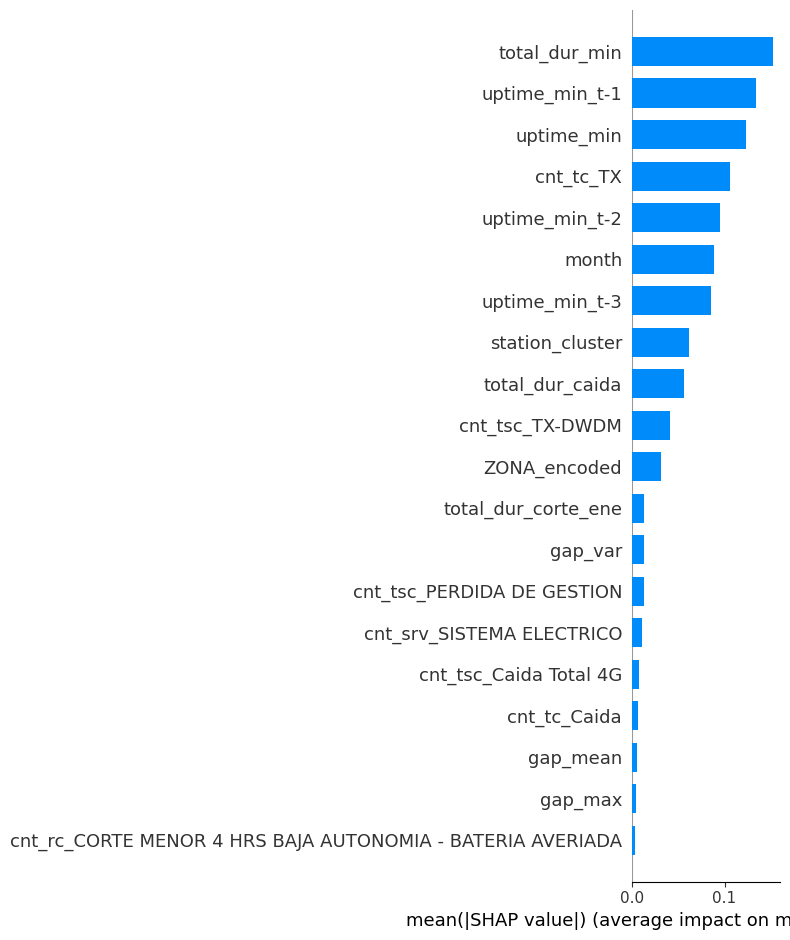


▶ Zona 2 — Top-10 variables
uptime_min_t-2                       0.1425
cnt_tc_Energia                       0.1338
month                                0.1232
uptime_min_t-1                       0.1063
uptime_min_t-3                       0.0989
uptime_min                           0.0608
cnt_tsc_Caida Parcial 4G             0.0365
uptime_rolling_mean_3w               0.0269
total_dur_min                        0.0265
gap_var                              0.0253


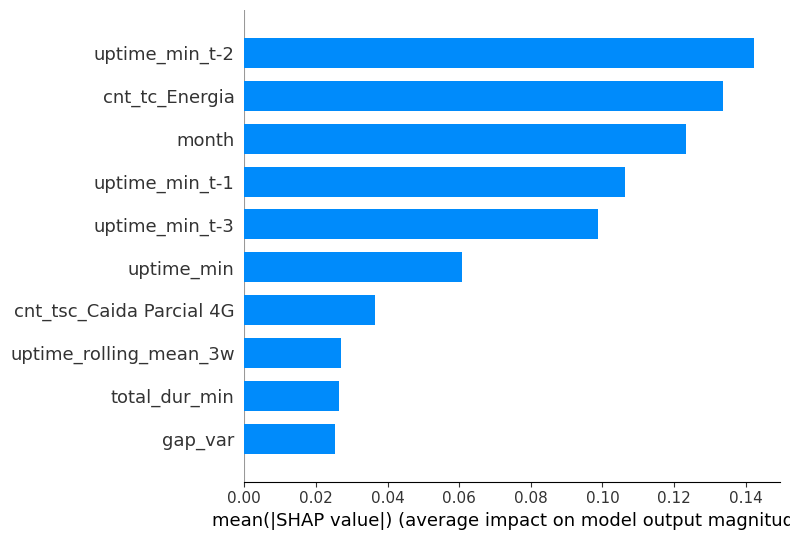


▶ Zona 7 — Top-10 variables
uptime_min_t-1                       0.1575
uptime_min                           0.1189
uptime_min_t-2                       0.0844
month                                0.0822
total_dur_min                        0.0684
station_cluster                      0.0534
uptime_min_t-3                       0.0462
cnt_tc_Corte_Energia                 0.0411
total_dur_caida                      0.0376
gap_var                              0.0353


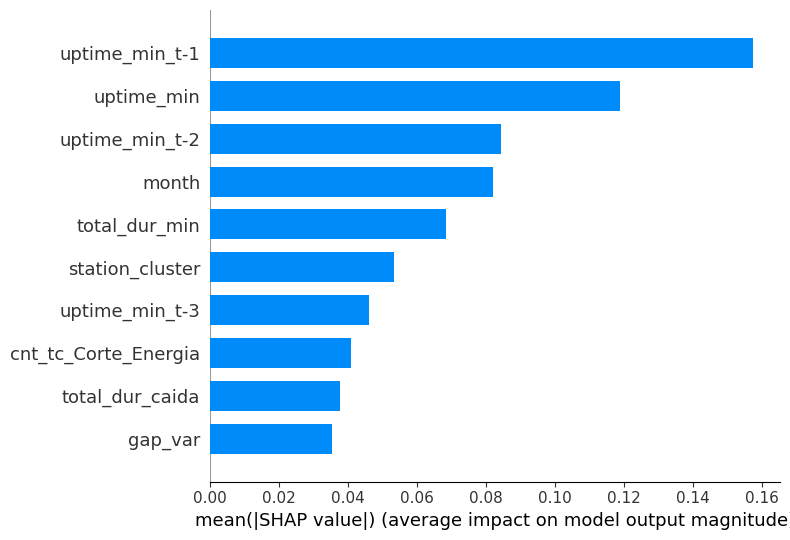


▶ Zona 8 — Top-10 variables
uptime_min                           0.1931
uptime_min_t-1                       0.1927
total_dur_min                        0.1378
month                                0.1320
uptime_min_t-3                       0.1070
cnt_tc_TX                            0.0940
uptime_min_t-2                       0.0893
station_cluster                      0.0747
total_dur_caida                      0.0532
cnt_tsc_TX-DWDM                      0.0379


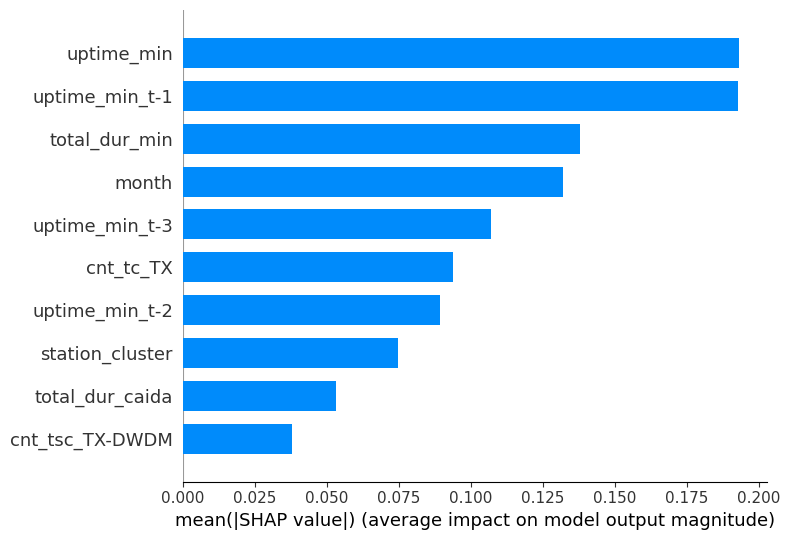


▶ Zona 1 — Top-10 variables
month                                0.1757
uptime_min_t-1                       0.1493
uptime_min_t-2                       0.0646
uptime_min                           0.0523
total_dur_min                        0.0422
total_dur_caida                      0.0392
uptime_min_t-3                       0.0313
gap_var                              0.0281
uptime_rolling_mean_3w               0.0189
gap_max                              0.0189


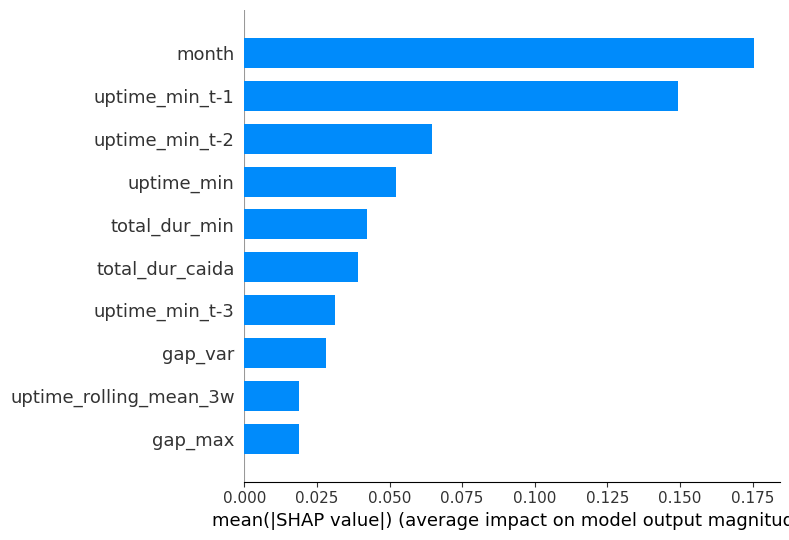


▶ Zona 5 — Top-10 variables
total_dur_min                        0.1793
month                                0.1721
uptime_min_t-2                       0.1611
station_cluster                      0.1266
uptime_min                           0.1204
uptime_min_t-1                       0.1163
gap_var                              0.0958
uptime_min_t-3                       0.0869
total_dur_caida_t-1                  0.0598
cnt_tsc_TX-DWDM                      0.0596


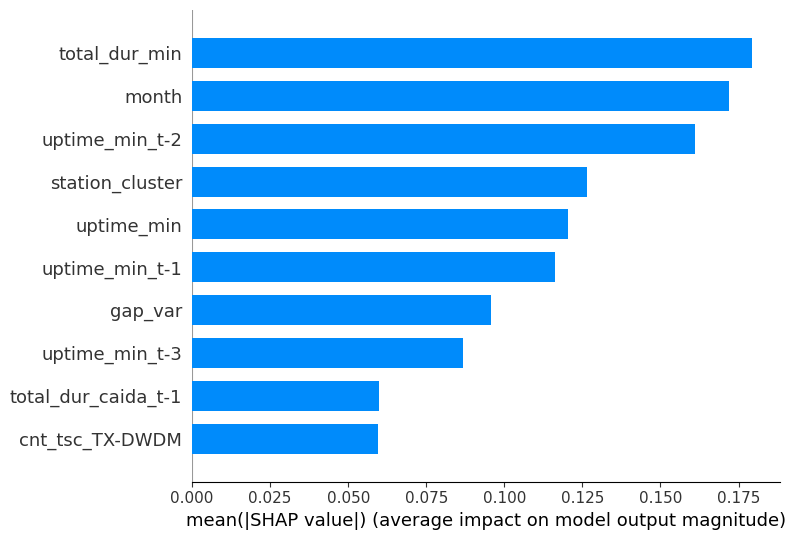


▶ Zona 3 — Top-10 variables
total_dur_min                        0.1594
month                                0.1458
uptime_min_t-2                       0.1443
gap_mean                             0.1338
uptime_min                           0.1280
uptime_rolling_mean_3w               0.1018
cnt_tsc_TX-DWDM                      0.0977
total_dur_caida                      0.0937
uptime_min_t-3                       0.0872
cnt_tc_TX                            0.0772


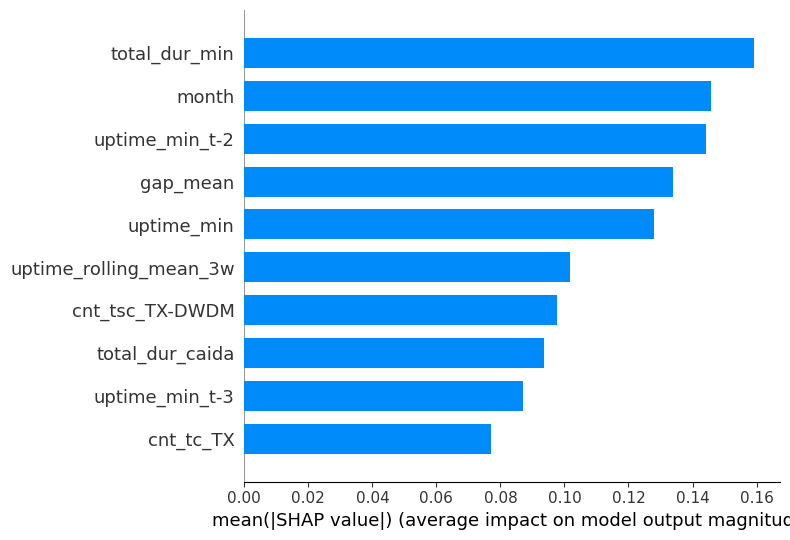


▶ Zona 0 — Top-10 variables
month                                0.2120
total_dur_min                        0.2013
uptime_min                           0.1640
uptime_min_t-1                       0.1545
uptime_min_t-3                       0.1484
uptime_min_t-2                       0.1412
n_tech                               0.1363
gap_var                              0.1346
uptime_rolling_mean_3w               0.1255
total_dur_corte_ene                  0.0701


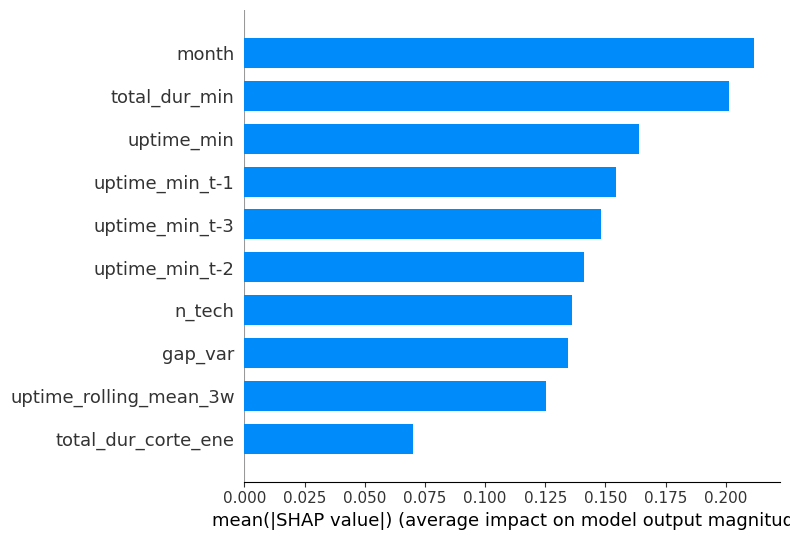


▶ Zona 6 — Top-10 variables
total_dur_min                        0.2798
uptime_min_t-1                       0.1213
uptime_min                           0.1181
gap_var                              0.0999
station_cluster                      0.0925
uptime_min_t-2                       0.0910
uptime_min_t-3                       0.0821
uptime_rolling_mean_3w               0.0634
month                                0.0614
total_dur_caida                      0.0536


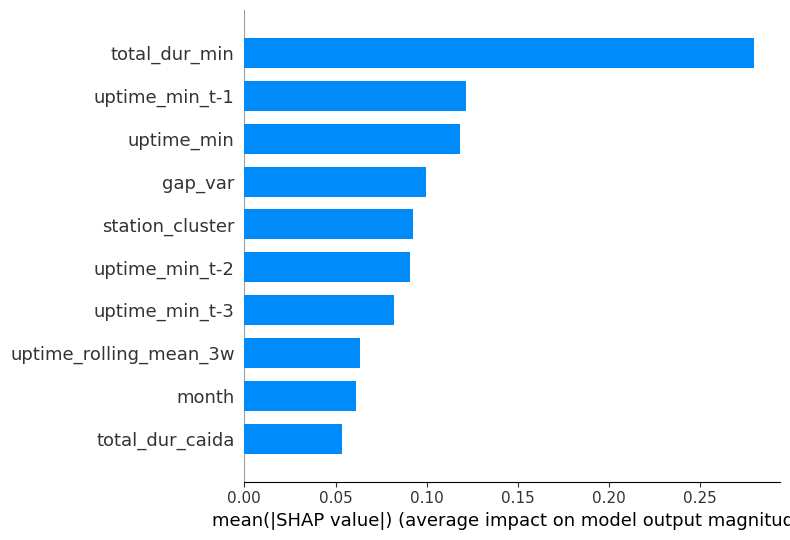


▶ Zona 9 — Top-10 variables
month                                0.6548
uptime_rolling_mean_3w               0.2607
uptime_min_t-2                       0.2052
gap_var                              0.1628
uptime_min_t-3                       0.1343
uptime_min_t-1                       0.1272
total_dur_min                        0.1234
n_tech                               0.0938
total_dur_corte_ene                  0.0870
total_dur_caida                      0.0818


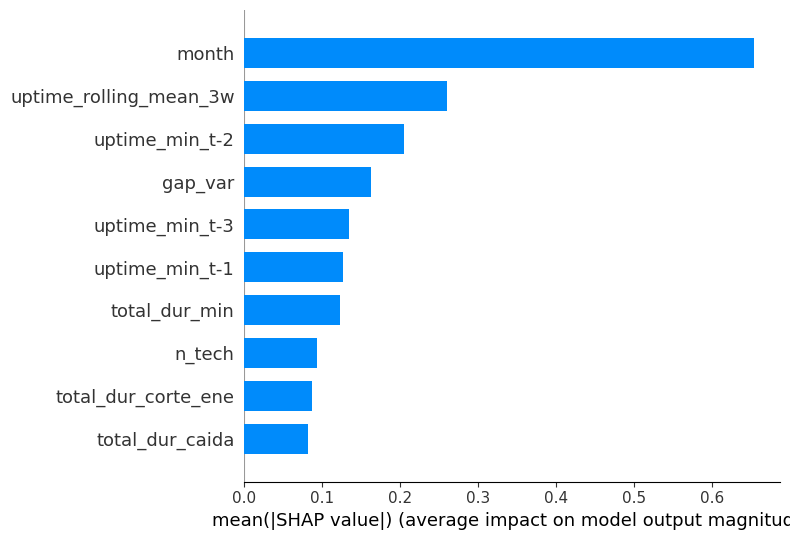


▶ Zona 4 — Top-10 variables
month                                0.1930
uptime_min_t-3                       0.1662
uptime_min_t-1                       0.1375
uptime_min_t-2                       0.0981
uptime_min                           0.0947
total_dur_min                        0.0793
station_cluster                      0.0742
uptime_rolling_mean_3w               0.0585
gap_var                              0.0401
total_dur_caida                      0.0370


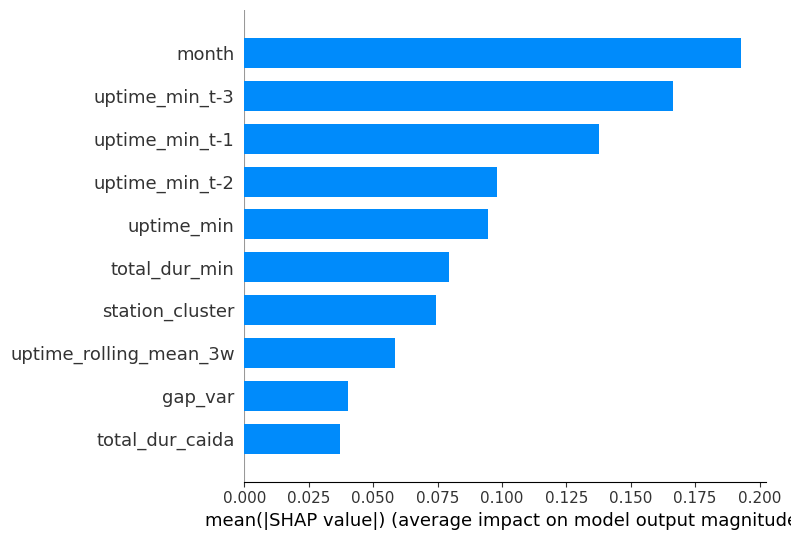

In [ ]:
shap.initjs()    
SAMPLE_SIZE   = 1000  
BACKGROUND    = X_full[features_total].sample(
                    n=min(SAMPLE_SIZE, len(X_full)),
                    random_state=260525)

explainer_gl = shap.TreeExplainer(model_global, data=BACKGROUND)
shap_values_gl = explainer_gl.shap_values(BACKGROUND)

# Modelo Global
print("▶ Top-20 variables (global):")
imp_gl = (np.abs(shap_values_gl).mean(axis=0))
top_idx = np.argsort(imp_gl)[-20:][::-1]
for i in top_idx:
    print(f"{features_total[i]:35s}  {imp_gl[i]:.4f}")

# summary bar plot
shap.summary_plot(shap_values_gl, BACKGROUND, plot_type="bar",
                  max_display=20, show=True)

# Modelos Locales
for zona in zonas_buen_local:           
    df_z   = df[df[zona_col] == zona]
    X_z_bg = df_z[features_total].sample(
                 n=min(300, len(df_z)), random_state=260525)
    expl_z = shap.TreeExplainer(modelos_por_zona[zona], data=X_z_bg)

    shap_vals_z = expl_z.shap_values(X_z_bg)

    print(f"\n▶ Zona {zona} — Top-10 variables")
    imp_z = (np.abs(shap_vals_z).mean(axis=0))
    top_z = np.argsort(imp_z)[-10:][::-1]
    for i in top_z:
        print(f"{features_total[i]:35s}  {imp_z[i]:.4f}")

    # gráfico resumen
    shap.summary_plot(shap_vals_z, X_z_bg, plot_type="bar",
                      max_display=10, show=True)


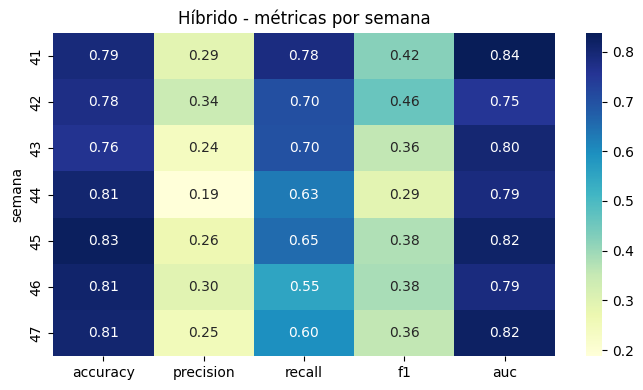

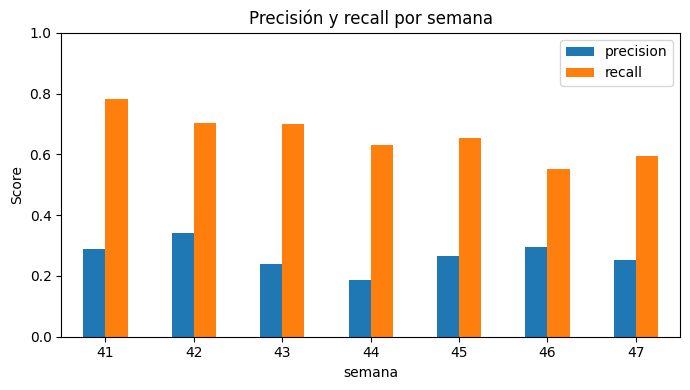

In [ ]:
metric_cols = ["accuracy", "precision", "recall", "f1", "auc"]

# Heat-map
plt.figure(figsize=(7, 4))
sns.heatmap(df_hibrido.set_index("semana")[metric_cols],
            annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Híbrido - métricas por semana")
plt.tight_layout()
plt.show()

# Barras apiladas
df_plot = df_hibrido.set_index("semana")[["precision", "recall"]]
df_plot.plot(kind="bar", stacked=False, figsize=(7,4))
plt.ylabel("Score")
plt.title("Precisión y recall por semana")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

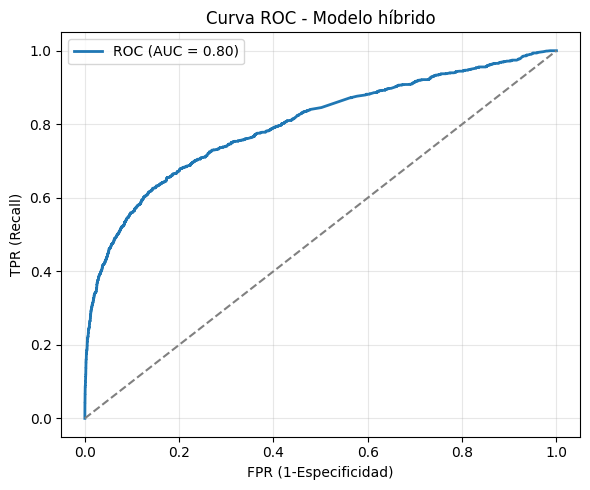

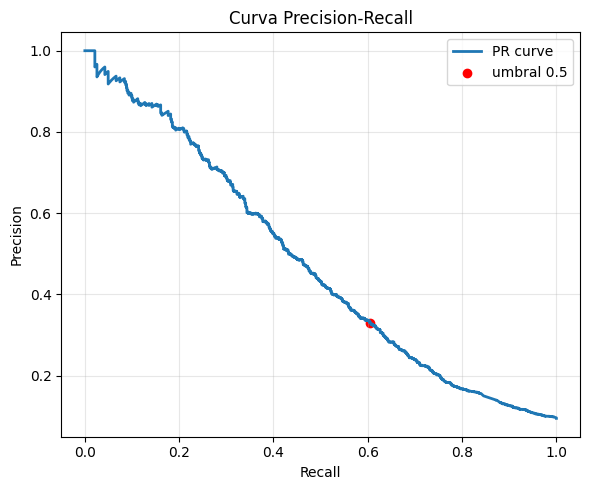

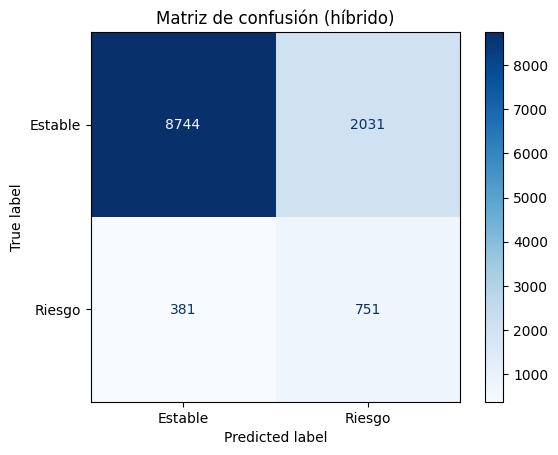

In [ ]:
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay
)
y_true   = np.concatenate(y_true_list) 
y_scores = np.concatenate(y_proba_list)
y_pred   = np.concatenate(y_pred_list)

# ROC 
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc     = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("FPR (1-Especificidad)"); plt.ylabel("TPR (Recall)")
plt.title("Curva ROC - Modelo híbrido")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# Precision-Recall
prec, rec, th = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, lw=2, label="PR curve")
# marca umbral 0.5
p05 = prec[np.argmin(np.abs(th-0.5))]
r05 = rec[np.argmin(np.abs(th-0.5))]
plt.scatter(r05, p05, color="red", label="umbral 0.5")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Estable","Riesgo"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusión (híbrido)")
plt.show()